# NLP with Cards Against Humanity
__Goals:__  
1. Given a randomly chosen question, generate answer (Word2Vec)
2. Classify the answers and questions & Topic modeling (Classification)
3. Generate answer cards (Bag of words, Markov Chain, RNN (no labeled, quantity) )

Ideas / To-dos:
- Word Tokenize then Vectorizer 
- Word2Vec to find relationships between Q & A, use that relationship to generate the answer
    - Use Google's Gensim
- Topic modeling on the Questions and Answer Cards using LSA/K-Means
    - ToDo: silouhette score for kMeans
- Word Generation for new questions and answers (RNN)

Challenges:
- Where the blanks go
- Short answers and questions
- Not having Word2Vec for it (no longer a concern)

### Extract the data

In [119]:
import urllib.request, json 
import urllib
import json
import pandas as pd
import os
from collections import Counter

In [2]:
os.chdir('/Users/bellepeng/Desktop/Metis/Projects/NLP_CardsAgainstHumanity/')

In [3]:
import json
with open("/Users/bellepeng/Desktop/Metis/Projects/NLP_CardsAgainstHumanity/cah.json") as json_data:
    cah = json.load(json_data)

In [4]:
print(cah.keys())
print("how many blackCards?", len(cah['blackCards']))
print("how many Base black?",len(cah['Base']['black']))
print("how many whiteCards?",len(cah['whiteCards']))
print("how many Base white?",len(cah['Base']['white']))
print(cah['Base']['name'])
print(cah['order'])

dict_keys(['blackCards', 'whiteCards', 'Base', 'CAHe1', 'CAHe2', 'CAHe3', 'CAHe4', 'CAHe5', 'CAHe6', 'greenbox', 'order'])
how many blackCards? 295
how many Base black? 90
how many whiteCards? 1155
how many Base white? 460
Base Set
['Base', 'CAHe1', 'CAHe2', 'CAHe3', 'CAHe4', 'CAHe5', 'CAHe6', 'greenbox']


In [5]:
keys=['Base', 'CAHe1', 'CAHe2', 'CAHe3', 'CAHe4', 'CAHe5', 'CAHe6', 'greenbox']
count_w=[]
for k in range(len(keys)):
    count_w.append(len(cah[keys[k]]['white']))

count_b=[]
for k in range(len(keys)):
    count_b.append(len(cah[keys[k]]['black']))

print("check total white cards:", sum(count_w))
print("check total black cards:", sum(count_b))

check total white cards: 1155
check total black cards: 295


In [6]:
whiteCards=cah['whiteCards']
print(len(whiteCards))
print(type(whiteCards))
whiteCards[:5]

1155
<class 'list'>


['Coat hanger abortions.',
 'Man meat.',
 'Autocannibalism.',
 'Vigorous jazz hands.',
 'Flightless birds.']

In [7]:
blackCards=[x['text'] for x in cah['blackCards']]
print(len(blackCards))
print(type(blackCards))
blackCards[:5]

295
<class 'list'>


["Why can't I sleep at night?",
 "I got 99 problems but _ ain't one.",
 "What's a girl's best friend?",
 "What's that smell?",
 'This is the way the world ends / This is the way the world ends / Not with a bang but with _.']

In [25]:
blackCards.pop(74)
blackCards.pop(131)
whiteCards.pop(614)

'Before _, all we had was _.'

### NLP Preprocessing

In [32]:
from __future__ import print_function
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from collections import Counter
from operator import itemgetter

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

In [420]:
# Remove Stop Words
stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"', 'got', 'br', 'getting', '&reg']
print(len(stop))
# itemsToRemove=['you', 'yourself', 'your', 'me', 'myself', 'our']
# stop = [x for x in stop if x not in itemsToRemove]
print(len(stop))

punctuations=['.', ',', '(', ')', "'", '"']

189
189


In [34]:
os.chdir('/Users/bellepeng/Desktop/Metis/Work/tools')
from nlp import fixContractions 

In [477]:
# Clean the text for Word2Vec
def clean_text(text):
    text=text.replace('&reg;', '')
    text=text.replace('&Reg;', '')
    lemmatize = WordNetLemmatizer()
    text = fixContractions(text)
    tokens = word_tokenize(text)
    clean_text = [lemmatize.lemmatize(token.lower().strip(), pos='a') for token in tokens]
    clean_text = [x for x in clean_text if x not in stop]
    return ' '.join(clean_text)

In [479]:
allCards = whiteCards+blackCards
cleaned_all=[clean_text(i) for i in allCards]
cleaned_w = [clean_text(i) for i in whiteCards]
cleaned_b = [clean_text(i) for i in blackCards]
print(cleaned_w[135])
print(cleaned_b[100])

tempur-pedic swedish sleep system & trade ;
learned hard way cheer grieving friend _


In [480]:
# Tokenize for other NLP
tokenized_w = [word_tokenize(i) for i in cleaned_w]
tokenized_b = [word_tokenize(i) for i in cleaned_b]
print(len(tokenized_w))
print(len(tokenized_b))

tokenized_w = list(filter(lambda x: len(x)!=0, tokenized_w))
tokenized_b = list(filter(lambda x: len(x)!=0, tokenized_b))
print(len(tokenized_w))
print(len(tokenized_b))
tokenized_w[:3]

1154
293
1153
293


[['coat', 'hanger', 'abortions'], ['man', 'meat'], ['autocannibalism']]

In [481]:
# Vectorize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
count_vectorizer = CountVectorizer(ngram_range=(1,1), stop_words=stop, lowercase=False)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words=stop, lowercase=False)

cv_w = [count_vectorizer.fit_transform(i) for i in tokenized_w]
tfidf_w = [tfidf_vectorizer.fit_transform(i) for i in tokenized_w]

cv_b = [count_vectorizer.fit_transform(i) for i in tokenized_b]
tfidf_b = [tfidf_vectorizer.fit_transform(i) for i in tokenized_b]

### Word2Vec
Calculate the Question Word Vecs ad Answer Word Vecs, then compute the distance

In [525]:
import gensim  # using skip-gram
from gensim.models import Word2Vec

In [526]:
def find_vec(text_list):
    text_str=[x.split() for x in text_list]
    model = gensim.models.Word2Vec(text_str, window=1, min_count=1, workers=1, sg=1)
    return model
    # list(model.wv.vocab.items())[:5]
    # model['love']
    #print(model.wv.most_similar('smegma'))

In [527]:
wordVec = find_vec((cleaned_w+cleaned_b))

In [528]:
# For each White Card, find the sum of the word vectors
cardVec_w = [sum(wordVec[x]) for x in tokenized_w]
print(len(cardVec_w))
cardVec_w_dict = dict(zip(whiteCards, cardVec_w))

1153


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [529]:
def cardVec_list(wordVec, tokenized_words):
    eachCard=[]
    for i in range(len(tokenized_words)):
        try:
            eachCard.append(wordVec[tokenized_words[i]])
        except:
            eachCard.append(0)   
    return eachCard

In [530]:
cardVec_list_b=[]
for i in range(len(tokenized_b)):
    cardVec_list_b.append(cardVec_list(wordVec, tokenized_b[i]))
    
len(cardVec_list_b)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


293

In [531]:
cardVec_b = [sum(x) for x in cardVec_list_b]
cardVec_b_dict = dict(zip(blackCards, cardVec_b))
cardVec_b_dict.keys()

dict_keys(["Why can't I sleep at night?", "I got 99 problems but _ ain't one.", "What's a girl's best friend?", "What's that smell?", 'This is the way the world ends / This is the way the world ends / Not with a bang but with _.', "What is Batman's guilty pleasure?", 'TSA guidelines now prohibit _ on airplanes.', 'What ended my last relationship?', "MTV's new reality show features eight washed-up celebrities living with _.", 'I drink to forget _.', "I'm sorry, Professor, but I couldn't complete my homework because of _.", 'Alternative medicine is now embracing the curative powers of _.', "What's that sound?", "What's the next Happy Meal&reg; toy?", "It's a pity that kids these days are all getting involved with _.", 'In the new Disney Channel Original Movie, Hannah Montana struggles with _ for the first time.', "_. That's how I want to die.", 'What does Dick Cheney prefer?', "What's the most emo?", 'Instead of coal, Santa now gives the bad children _.', 'Next from J.K. Rowling: Harry P

In [532]:
cardVec_w_dict.keys()

dict_keys(['Coat hanger abortions.', 'Man meat.', 'Autocannibalism.', 'Vigorous jazz hands.', 'Flightless birds.', 'Pictures of boobs.', 'Doing the right thing.', 'The violation of our most basic human rights.', 'Viagra&reg;.', 'Self-loathing.', 'Spectacular abs.', 'A balanced breakfast.', 'Roofies.', 'Concealing a boner.', 'Amputees.', 'The Big Bang.', 'Former President George W. Bush.', 'The Rev. Dr. Martin Luther King, Jr.', 'Smegma.', 'Being marginalized.', 'Cuddling.', 'Laying an egg.', 'The Pope.', 'Aaron Burr.', 'Genital piercings.', 'Fingering.', 'A bleached asshole.', 'Horse meat.', 'Fear itself.', 'Science.', 'Elderly Japanese men.', 'Stranger danger.', 'The terrorists.', 'Praying the gay away.', 'Same-sex ice dancing.', 'Ethnic cleansing.', 'Cheating in the Special Olympics.', 'German dungeon porn.', 'Bingeing and purging.', 'Making a pouty face.', 'William Shatner.', 'Heteronormativity.', 'Nickelback.', 'Tom Cruise.', 'The profoundly handicapped.', 'The placenta.', 'Chainsa

In [533]:
distances=[]
for question in range(len(tokenized_b)):
    X = cardVec_b[question]
    
    answers=[]
    for answer in range(len(tokenized_w)):
        Z = [X, cardVec_w[answer]]
        answers.append(cosine_similarity(Z)[0][1])
    
    distances.append(answers)      

In [534]:
print(len(distances[0]))
len(distances)

1153


293

In [49]:
# import pickle
# with open('CAH_distances.pkl', 'wb') as picklefile:
#     pickle.dump(distances, picklefile)

I got 99 problems but _ ain't one.  
Min: Being a motherfucking sorcerer.  
Max: One thousand Slim Jims.  

Why can't I sleep at night?  
Min: Friendly fire.  
Max: Bees?  

In [50]:
for q in range(len(blackCards)):
    print(blackCards[q])
    max_answer=distances[q].index(max(distances[q]))
    min_answer=distances[q].index(min(distances[q]))
    print("Least Expected Answer:", whiteCards[min_answer])
    print("Most Expected Answer:", whiteCards[max_answer])
    print("\n")

Why can't I sleep at night?
Least Expected Answer: Getting trapped in a conversation about Ayn Rand.
Most Expected Answer: An M. Night Shyamalan plot twist.


I got 99 problems but _ ain't one.
Least Expected Answer: Sexual tension.
Most Expected Answer: One trillion dollars.


What's a girl's best friend?
Least Expected Answer: Getting trapped in a conversation about Ayn Rand.
Most Expected Answer: Bees?


What's that smell?
Least Expected Answer: A snapping turtle biting the tip of your penis.
Most Expected Answer: Bees?


This is the way the world ends / This is the way the world ends / Not with a bang but with _.
Least Expected Answer: Turning the rivers red with the blood of infidels.
Most Expected Answer: The World of Warcraft.


What is Batman's guilty pleasure?
Least Expected Answer: Social justice warriors with flamethrowers of compassion.
Most Expected Answer: Daddy's belt.


TSA guidelines now prohibit _ on airplanes.
Least Expected Answer: Getting naked and watching Nickelo



Behind every powerful man is _.
Least Expected Answer: Eating ass.
Most Expected Answer: Meatloaf, the man.


You are not alone. Millions of Americans struggle with _ every day.
Least Expected Answer: A spontaneous conga line.
Most Expected Answer: Becoming the President of the United States.


Come to Dubai, where you can relax in our world famous spas, experience the nightlife, or simply enjoy _ by the poolside.
Least Expected Answer: Getting pegged.
Most Expected Answer: Fucking my therapist.


"This is madness." "No, THIS IS _!"
Least Expected Answer: Child support payments.
Most Expected Answer: The color "puce".


Listen Gary, I like you. But if you want that corner office, you're going to have to show me _.
Least Expected Answer: Foreskin.
Most Expected Answer: A bunch of idiots playing a card game instead of interacting like normal humans.


I went to the desert and ate of the peyote cactus. Turns out my spirit animal is _.
Least Expected Answer: Sharing needles.
Most Expecte

#### Generate a Labeled Dataset using W2V

In [558]:
# For Generating a Labeled Dataset
w2v_pred_matrix=[]
w2v_pred_words=[]

for q in range(len(blackCards)):
    answer_min = distances[q].index(min(distances[q]))
    answer_25 = distances[q].index(np.percentile(distances[q], 25))
    answer_med = distances[q].index(np.median(distances[q]))
    answer_75 = distances[q].index(np.percentile(distances[q], 75))
    answer_max = distances[q].index(max(distances[q]))
    answers = [answer_min, answer_25, answer_med, answer_75, answer_max]
    w2v_pred_matrix.append(answers)
    
    words_min = tokenized_w[distances[q].index(min(distances[q]))]
    words_25 = tokenized_w[distances[q].index(np.percentile(distances[q], 25))]
    words_med = tokenized_w[distances[q].index(np.median(distances[q]))]
    words_75 = tokenized_w[distances[q].index(np.percentile(distances[q], 75))]
    words_max = tokenized_w[distances[q].index(max(distances[q]))]
    words = [tokenized_b[q], words_min, words_25, words_med, words_75, words_max]
    w2v_pred_words.append(words)

In [559]:
print(w2v_pred_matrix[:5])
w2v_pred_words[0]

[[1019, 482, 952, 297, 327], [308, 676, 633, 1080, 576], [1019, 306, 423, 644, 242], [225, 306, 402, 520, 242], [895, 445, 186, 180, 182]]


[['sleep', 'night', '?'],
 ['trapped', 'conversation', 'ayn', 'rand'],
 ['moral', 'ambiguity'],
 ['bad', 'emotions', 'want'],
 ['passable', 'transvestites'],
 ['m.', 'night', 'shyamalan', 'plot', 'twist']]

In [563]:
from itertools import chain
w2v_pred_words_flat = [list(chain.from_iterable(x)) for x in w2v_pred_words]
print(len(w2v_pred_words_flat))
w2v_pred_words_flat[:5]

293


[['sleep',
  'night',
  '?',
  'trapped',
  'conversation',
  'ayn',
  'rand',
  'moral',
  'ambiguity',
  'bad',
  'emotions',
  'want',
  'passable',
  'transvestites',
  'm.',
  'night',
  'shyamalan',
  'plot',
  'twist'],
 ['99',
  'problems',
  '_',
  'one',
  'sexual',
  'tension',
  'moist',
  'demanding',
  'chasm',
  'mouth',
  'actually',
  'shot',
  'real',
  'prematurely',
  'ejaculating',
  'like',
  'total',
  'loser',
  'one',
  'ring',
  'rule'],
 ['girl',
  "'s",
  'best',
  'friend',
  '?',
  'trapped',
  'conversation',
  'ayn',
  'rand',
  'black',
  'people',
  'consensual',
  'sex',
  'black',
  'male',
  'early',
  '20s',
  'last',
  'seen',
  'wearing',
  'hoodie',
  'bees',
  '?'],
 ['smell',
  '?',
  'snapping',
  'turtle',
  'biting',
  'tip',
  'penis',
  'black',
  'people',
  'firing',
  'rifle',
  'air',
  'balls',
  'deep',
  'squealing',
  'hog',
  'low',
  'standard',
  'living',
  'bees',
  '?'],
 ['way',
  'world',
  'ends',
  '/',
  'way',
  'world

In [566]:
# Vectorize
count_vec_pred = CountVectorizer(ngram_range=(1,1), stop_words=stop, lowercase=False)
tfidf_vec_pred = TfidfVectorizer(ngram_range=(1,1), stop_words=stop, lowercase=False)

cv_w2v = [count_vec_pred.fit_transform(i) for i in w2v_pred_words_flat]
tfidf_w2v = [tfidf_vec_pred.fit_transform(i) for i in w2v_pred_words_flat]

print(cv_w2v[0])
print(tfidf_w2v[0])

  (0, 11)	1
  (1, 6)	1
  (3, 13)	1
  (4, 3)	1
  (5, 1)	1
  (6, 9)	1
  (7, 5)	1
  (8, 0)	1
  (9, 2)	1
  (10, 4)	1
  (11, 15)	1
  (12, 7)	1
  (13, 12)	1
  (15, 6)	1
  (16, 10)	1
  (17, 8)	1
  (18, 14)	1
  (0, 11)	1.0
  (1, 6)	1.0
  (3, 13)	1.0
  (4, 3)	1.0
  (5, 1)	1.0
  (6, 9)	1.0
  (7, 5)	1.0
  (8, 0)	1.0
  (9, 2)	1.0
  (10, 4)	1.0
  (11, 15)	1.0
  (12, 7)	1.0
  (13, 12)	1.0
  (15, 6)	1.0
  (16, 10)	1.0
  (17, 8)	1.0
  (18, 14)	1.0


In [51]:
# Google Word2Vec
# Avg instead of sum so i'm not penalized by words not in the dictionary

### Topic Modeling

In [52]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD

In [482]:
# Vectorize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer_count_w = CountVectorizer(ngram_range=(1, 1), stop_words=stop, lowercase=False)
vectorizer_tfidf_w = TfidfVectorizer(ngram_range=(1, 1), stop_words=stop, lowercase=False)
vectorizer_count_b = CountVectorizer(ngram_range=(1, 1), stop_words=stop, lowercase=False)
vectorizer_tfidf_b = TfidfVectorizer(ngram_range=(1, 1), stop_words=stop, lowercase=False)

cv_w = vectorizer_count_w.fit_transform(cleaned_w)
cv_b = vectorizer_count_b.fit_transform(cleaned_b)
tfidf_w = vectorizer_tfidf_w.fit_transform(cleaned_w)
tfidf_b = vectorizer_tfidf_b.fit_transform(cleaned_b)

In [423]:
def display_topics(model, fit, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic {a:} score: {b: 6.1f}%".format(a=ix, b=100*sum(fit[:,ix])/fit.sum()   ))
        else:
            print("\nTopic {a:} score: {b: 6.1f}%".format(a=topic_names[ix], b=100*sum(fit[:,ix])/fit.sum()   ))
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

#### NMF_CV and LSA_TFIDF were the chosen Topic Modeling Techniques

In [483]:
n_comp = 6
nm_cv = NMF(n_components=n_comp)
nm_cv_data_W = nm_cv.fit_transform(cv_w)
display_topics(nm_cv, nm_cv_data_W, vectorizer_count_w.get_feature_names(), 10)


Topic 0 score:   14.9%
sex, person, life, good, right, money, high, really, horse, eternal

Topic 1 score:   17.6%
man, old, body, goat, head, year, every, vagina, pants, power

Topic 2 score:   16.8%
people, going, old, life, way, around, white, black, kill, homeless

Topic 3 score:    9.0%
balls, eyes, taking, putting, go, holes, eye, man, deep, rifle

Topic 4 score:   16.9%
like, eating, ass, god, bad, shitting, playing, damn, vomiting, new

Topic 5 score:   24.7%
big, penis, full, black, dick, one, mouth, huge, horse, face


In [56]:
# Understanding the NMF Decomposition
print("Document X Topic:", nm_cv_data_W.shape)
print("Topic X Words:", nm_cv.components_.shape)

Document X Topic: (1154, 10)
Topic X Words: (10, 2220)


In [217]:
card_index = 0
whiteCards[card_index], nm_cv_data_W[card_index]/nm_cv_data_W[card_index].sum()

('Coat hanger abortions.',
 array([0.04012226, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.95987774]))

In [484]:
n_comp = 6
lsa_tfidf = TruncatedSVD(n_components=n_comp)
lsa_tfidf_data_w = lsa_tfidf.fit_transform(tfidf_w)
display_topics(lsa_tfidf, lsa_tfidf_data_w, vectorizer_tfidf_w.get_feature_names(), 10)


Topic 0 score:   31.0%
sex, people, man, life, eating, awesome, mom, surprise, person, dungeon

Topic 1 score:   19.7%
people, black, white, old, hot, eating, homeless, way, going, killed

Topic 2 score:   17.9%
man, old, meat, eating, meatloaf, milk, head, body, folly, year

Topic 3 score:    8.8%
ass, eating, mouth, like, cancer, whoop, disaster, albino, kids, shit

Topic 4 score:   13.0%
dick, black, big, ass, good, children, mouth, fingers, cheney, obama

Topic 5 score:    9.6%
hot, soup, ass, friends, pockets, lettuce, mess, cheese, dick, shit


In [269]:
card_index = 100
whiteCards[card_index], lsa_tfidf_data_w[card_index]/lsa_tfidf_data_w[card_index].sum()

('Teaching a robot to love.',
 array([ 0.10598603, -0.03009037, -0.00668206,  0.17477302,  0.10740341,
         0.64860996]))

#### Attempts that are not chosen as results

In [262]:
n_comp = 6
lsa_cv = TruncatedSVD(n_components=n_comp)
lsa_cv_data_W = lsa_cv.fit_transform(cv_w)
display_topics(lsa_cv, lsa_cv_data_W, vectorizer_count_w.get_feature_names(), 10)


Topic 0 score:   55.5%
sex, man, getting, balls, people, old, eyes, eating, head, life

Topic 1 score:   15.3%
man, getting, balls, eyes, old, taking, dick, putting, go, shot

Topic 2 score:  -17.2%
man, balls, eyes, old, taking, go, putting, holes, eye, body

Topic 3 score:   22.0%
people, old, black, going, full, way, around, white, life, kill

Topic 4 score:   25.1%
reg, trade, fun, child, pretty, face, balls, chicken, stuff, taking

Topic 5 score:   -0.7%
balls, eyes, taking, putting, go, holes, eye, big, sex, full


In [175]:
# # Try to model the blackcards - results aren't very good, so combine them both
# n_comp = 6
# nm_cv_b = NMF(n_components=n_comp)
# nm_cv_data_b = nm_cv_b.fit_transform(cv_b)
# display_topics(nm_cv_b, nm_cv_data_b, vectorizer_count_b.get_feature_names(), 10)

In [177]:
# # LDA
# from sklearn.decomposition import LatentDirichletAllocation
# n_comp = 10
# lda = LatentDirichletAllocation(n_components=n_comp, max_iter=5, learning_method='online', learning_offset=50.,\
#                                 random_state=0).fit_transform(cv_w)
# print(lda.shape)
# lda[0]

#### Topic model with the White and Black Cards together

In [203]:
# Combine the black and white cards
vectorizer_count = CountVectorizer(ngram_range=(1, 1), stop_words=stop, lowercase=False)
cv_data = vectorizer_count.fit_transform(cleaned_all)

n_comp = 8
nm_cv = NMF(n_components=n_comp)
nm_cv_data = nm_cv.fit_transform(cv_data)

# Understanding the NMF Decomposition
print("Document X Topic:", nm_cv_data.shape)
print("Topic X Words:", nm_cv.components_.shape)

display_topics(nm_cv, nm_cv_data, vectorizer_count.get_feature_names(), 10)

Document X Topic: (1447, 8)
Topic X Words: (8, 2925)

Topic 0 score:    4.3%
obama, barack, google, complete, top, height, auto, worth, results, net

Topic 1 score:   11.0%
like, love, never, would, live, dance, watching, hurt, nobody, little

Topic 2 score:   14.1%
man, balls, eyes, old, body, every, taking, go, putting, goat

Topic 3 score:   11.6%
one, thing, get, would, good, summer, night, ready, god, big

Topic 4 score:   14.5%
sex, life, person, good, right, penis, really, high, want, eating

Topic 5 score:   17.0%
new, reg, time, child, might, must, movie, good, discovers, coming

Topic 6 score:   11.9%
getting, dick, shot, high, kids, naked, cannon, eaten, stuff, another

Topic 7 score:   15.5%
world, people, way, ends, war, fought, going, old, white, life


In [212]:
card_index = 0
cleaned_all[card_index], nm_cv_data[card_index]/nm_cv_data[card_index].sum()

('coat hanger abortions',
 array([0.        , 0.        , 0.        , 0.00471043, 0.99528957,
        0.        , 0.        , 0.        ]))

### Clustering

In [63]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import silhouette_score

#### KMeans

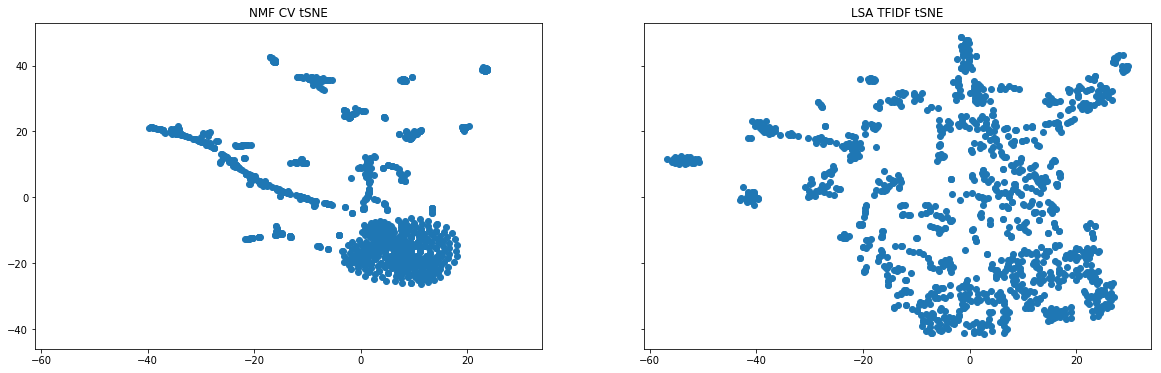

In [496]:
# Finding the right # of clusters using TSNE
tsne = TSNE(n_components = 2, perplexity = 30.0)
nm_cv_sne = tsne.fit_transform(nm_cv_data_W)
lsa_tfidf_sne = tsne.fit_transform(lsa_tfidf_data_w)

f, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20,6))
f.subplots_adjust(hspace=0.3)

ax[0].set_title('NMF CV tSNE')
ax[0].plot(nm_cv_sne[:, 0], nm_cv_sne[:, 1],'o')
ax[1].set_title('LSA TFIDF tSNE')
ax[1].plot(lsa_tfidf_sne[:, 0], lsa_tfidf_sne[:, 1],'o')

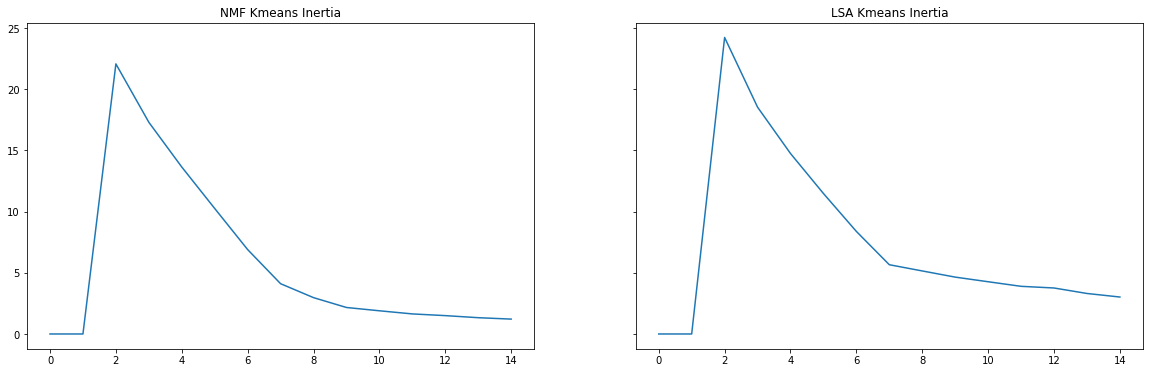

In [497]:
inertia_lsa = [0,0]
inertia_nmf = [0,0]
for n_clusters in range(2, 15):
    km_nmf = KMeans(n_clusters = n_clusters)
    km_nmf.fit(nm_cv_data_W)
    msg_nmf = f"""# clusters: {n_clusters:2d}   Inertia: {km_nmf.inertia_:8.6f}"""
    inertia_nmf.append(km_nmf.inertia_)
    # print(msg_nmf)
    
    km_lsa = KMeans(n_clusters = n_clusters)
    km_lsa.fit(lsa_tfidf_data_w)
    msg_lsa = f"""# clusters: {n_clusters:2d}   Inertia: {km_lsa.inertia_:8.6f}"""
    inertia_lsa.append(km_lsa.inertia_)
    # print(msg_lsa)

f, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20,6))
f.subplots_adjust(hspace=0.3)

ax[0].set_title('NMF Kmeans Inertia')
ax[0].plot(inertia_nmf)
ax[1].set_title('LSA Kmeans Inertia')
ax[1].plot(inertia_lsa)

# Based on this result I will choose n_clusters = 6

In [501]:
def eval_kmeans(X, n_clusters):
    km = KMeans(n_clusters = n_clusters)
    km.fit(X)
    print(f"""# clusters: {n_clusters:2d}   Inertia: {km.inertia_:8.6f}     Silouette Score: {metrics.silhouette_score(X, labels)}""")
    return km.predict(X)

In [503]:
km_lsa = eval_kmeans(lsa_tfidf_data_w, n_clusters=6)
km_nmf = eval_kmeans(nm_cv_data_W, n_clusters=6)

# clusters:  6   Inertia: 8.382875     Silouette Score: 0.7379880602713703
# clusters:  6   Inertia: 6.900080     Silouette Score: 0.8591487602826989


<Figure size 600x400 with 0 Axes>

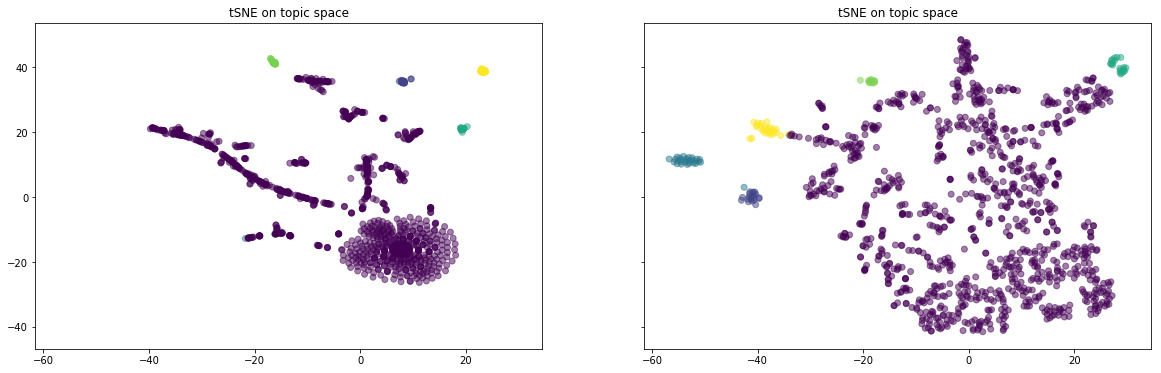

In [505]:
plt.figure(dpi=100)

f, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20,6))
f.subplots_adjust(hspace=0.3)

ax[0].set_title('tSNE on topic space')
ax[0].scatter(nm_cv_sne[:, 0], nm_cv_sne[:, 1], c=km_nmf, alpha=0.5)
ax[1].set_title('tSNE on topic space')
ax[1].scatter(lsa_tfidf_sne[:, 0], lsa_tfidf_sne[:, 1], c=km_lsa, alpha=0.5)

__Look at the clusters__

In [507]:
kmeans_nmf_labels = pd.concat([pd.DataFrame(cleaned_w), pd.DataFrame(km_nmf)], axis=1)
kmeans_nmf_labels.columns=['Answer', 'Label']
Counter(kmeans_nmf_labels['Label'])

Counter({0: 1055, 1: 25, 5: 27, 4: 24, 3: 22, 2: 1})

In [516]:
# kmeans_nmf_labels[kmeans_nmf_labels['Label']==0][:20]
# kmeans_nmf_labels[kmeans_nmf_labels['Label']==1] # Man
# kmeans_nmf_labels[kmeans_nmf_labels['Label']==2] # Eyes
# kmeans_nmf_labels[kmeans_nmf_labels['Label']==3] # Peopel
# kmeans_nmf_labels[kmeans_nmf_labels['Label']==4] # Eating and like
# kmeans_nmf_labels[kmeans_nmf_labels['Label']==5] # Sex

,Answer,Label
597,taking man 's eyes balls putting eyes balls go...,2


In [517]:
kmeans_lsa_labels = pd.concat([pd.DataFrame(cleaned_w), pd.DataFrame(km_lsa)], axis=1)
kmeans_lsa_labels.columns=['Answer', 'Label']
Counter(kmeans_lsa_labels['Label'])

Counter({0: 1049, 5: 27, 2: 28, 3: 20, 1: 20, 4: 10})

In [524]:
# kmeans_lsa_labels[kmeans_lsa_labels['Label']==0][:20]
# kmeans_lsa_labels[kmeans_lsa_labels['Label']==1] # People
# kmeans_lsa_labels[kmeans_lsa_labels['Label']==2] # Sex
# kmeans_lsa_labels[kmeans_lsa_labels['Label']==3] # Eating
kmeans_lsa_labels[kmeans_lsa_labels['Label']==4] # hot
# kmeans_lsa_labels[kmeans_lsa_labels['Label']==5] # Man

,Answer,Label
188,hot pockets,4
285,hot mess,4
304,hot people,4
368,hot cheese,4
378,soup hot,4
820,shit-hot guitar licks,4
1034,hot lettuce,4
1061,brother 's hot friends,4
1124,hot milf dallas,4
1145,watching hot person eat,4


#### DB Scan

In [287]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [485]:
X_lsa_tfidf_data_w = StandardScaler().fit_transform(lsa_tfidf_data_w)
X_nm_cv_data_W = StandardScaler().fit_transform(nm_cv_data_W)

In [433]:
def eval_dbscan(X, eps, min_samples):
    clusters = []
    silhouette_scores = []
    for i in range(len(eps)):
        # Compute DBSCAN
        db = DBSCAN(eps=eps[i], min_samples=min_samples).fit(X)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        # print('Estimated number of clusters: %d' % n_clusters_)
        # print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(X, labels))
        clusters.append(n_clusters_)
        silhouette_scores.append(metrics.silhouette_score(X, labels))
    return pd.DataFrame(list(zip(eps, clusters, silhouette_scores)), columns=['eps', 'clusters', 'silhouette_scores'])

                 0  eps  clusters  silhouette_scores
22  X_nm_cv_data_W  2.3         5           0.864719
23  X_nm_cv_data_W  2.4         5           0.864719
21  X_nm_cv_data_W  2.2         5           0.863818
20  X_nm_cv_data_W  2.1         5           0.859468
19  X_nm_cv_data_W  2.0         5           0.859468


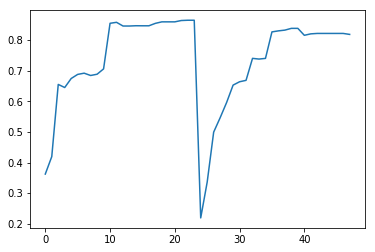

In [486]:
eps = np.arange(0.1, 2.5, 0.1)
min_samples=3
name = ['X_nm_cv_data_W']*len(eps) + ['X_lsa_tfidf_data_w']*len(eps)
X = [X_nm_cv_data_W, X_lsa_tfidf_data_w]

db_nm = eval_dbscan(X_nm_cv_data_W, eps, min_samples)
db_lsa = eval_dbscan(X_lsa_tfidf_data_w, eps, min_samples)
db_all = pd.concat([db_nm, db_lsa], axis=0).reset_index()
db_all = pd.merge(pd.DataFrame(name), db_all, left_index=True, right_index=True)
db_all.drop(labels = ['index'], axis=1, inplace=True)
print(db_all.sort_values(by='silhouette_scores', ascending = False)[:5])

plt.plot(db_all['silhouette_scores'])
# Based on this results, I pick eps=2.3, X_nm_cv_data_W

Estimated number of clusters: 5
Silhouette Coefficient: 0.865


Text(0.5,1,'Estimated number of clusters: 5')

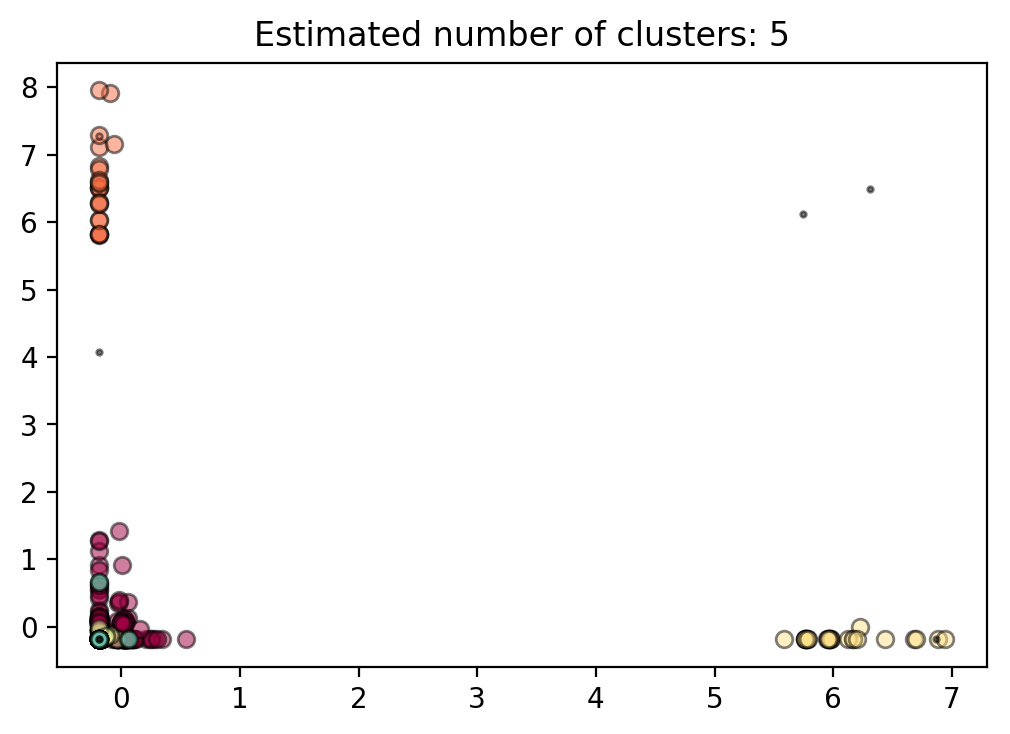

In [487]:
# Compute DBSCAN and Plot the Chosen parameters
X = X_nm_cv_data_W
eps=2.3
min_samples=3
db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(X, labels))

plt.figure(dpi=200)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6, alpha=0.5)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=2, alpha=0.5)

plt.title('Estimated number of clusters: %d' % n_clusters_)

Counter({0: 1054, 2: 27, 3: 24, 1: 23, 4: 20, -1: 6})


(array([   6., 1054.,   23.,   27.,   44.]),
 array([-1.,  0.,  1.,  2.,  3.,  4.]),
 <a list of 5 Patch objects>)

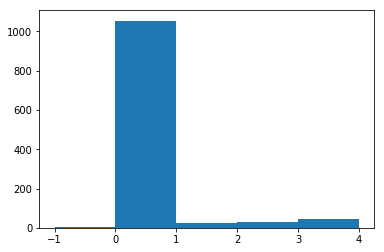

In [488]:
print(Counter(labels))
plt.hist(labels, bins=5)

In [489]:
dbscan_labels = pd.concat([pd.DataFrame(cleaned_w), pd.DataFrame(labels)], axis=1)
dbscan_labels.columns=['Answer', 'Label']

In [495]:
dbscan_labels[dbscan_labels['Label']==0][:20]
# dbscan_labels[dbscan_labels['Label']==1] #Man
# dbscan_labels[dbscan_labels['Label']==2] #Sex
# dbscan_labels[dbscan_labels['Label']==3] #Eating and like
# dbscan_labels[dbscan_labels['Label']==4] # Peopel
# dbscan_labels[dbscan_labels['Label']== -1] #F-ed up violence

,Answer,Label
0,coat hanger abortions,0
2,autocannibalism,0
3,vigorous jazz hands,0
4,flightless birds,0
5,pictures boobs,0
6,right thing,0
7,violation basic human rights,0
8,viagra,0
9,self-loathing,0
10,spectacular abs,0


#### Not using

[0.00934901 0.00915374 0.00867205 0.00750075 0.0070236  0.00665537
 0.00590909 0.00515451 0.0052755  0.00480675]
[5.90951596 5.57760141 5.43678995 5.08170682 4.93701365 4.7361396
 4.50894425 4.24894714 4.21849413 4.0347939 ]
(10, 2220)


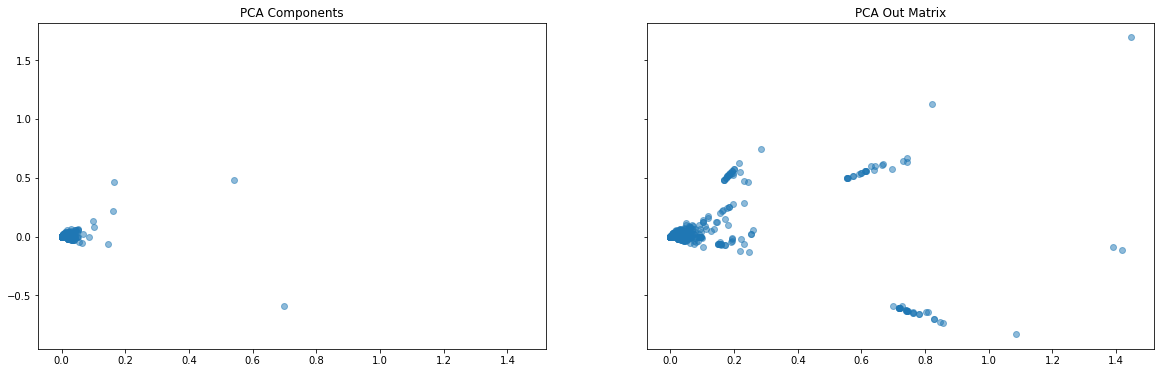

In [118]:
# For Visualization
n_comp = 10
pca_cv = TruncatedSVD(n_components=n_comp)
pca_cv_data_W = pca_cv.fit_transform(cv_w)
print(pca_cv.explained_variance_ratio_)  
print(pca_cv.singular_values_) 
print(pca_cv.components_.shape)

f, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20,6))
f.subplots_adjust(hspace=0.3)

ax[0].set_title('PCA Components')
ax[0].plot(pca_cv.components_[0, :], pca_cv.components_[1, :], 'o', alpha=0.5)
ax[1].set_title('PCA Out Matrix')
ax[1].plot(pca_cv_data_W[:,0], pca_cv_data_W[:,1], 'o', alpha=0.5)

Counter({0: 957, 9: 55, 4: 29, 3: 26, 1: 22, 2: 21, 5: 19, 6: 12, 8: 12, 7: 1})


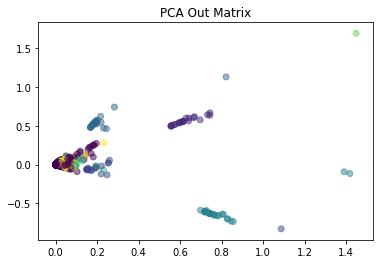

In [171]:
# For Visualization
n_clusters = 10
km2 = KMeans(n_clusters = n_clusters)
km2.fit(pca_cv_data_W)
print(Counter(km2.labels_))

plt.title('PCA Out Matrix')
plt.scatter(pca_cv_data_W[:,0], pca_cv_data_W[:,1], c=km2.labels_, alpha=0.5)

### RNN

In [219]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [237]:
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5
print(inputs)
print()
# # initialize the hidden state.
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
print(hidden)
print()
for i in inputs:
#     # Step through the sequence one element at a time.
#     # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)
    print(out, hidden)
    print()

[tensor([[-0.5576, -0.4004, -0.1611]]), tensor([[1.6806, 0.8899, 0.7150]]), tensor([[1.6324, 0.0333, 0.3113]]), tensor([[ 0.7473, -1.5173,  1.0968]]), tensor([[-0.4707,  1.4109,  0.8930]])]

(tensor([[[ 0.5312,  0.4164, -2.0819]]]), tensor([[[ 1.8215,  1.4218, -0.1352]]]))

tensor([[[ 0.1960,  0.3304, -0.0140]]], grad_fn=<CatBackward>) (tensor([[[ 0.1960,  0.3304, -0.0140]]], grad_fn=<ViewBackward>), tensor([[[ 0.9050,  0.5521, -0.0185]]], grad_fn=<ViewBackward>))

tensor([[[ 0.2625, -0.1113, -0.0187]]], grad_fn=<CatBackward>) (tensor([[[ 0.2625, -0.1113, -0.0187]]], grad_fn=<ViewBackward>), tensor([[[ 0.4410, -0.2044, -0.0255]]], grad_fn=<ViewBackward>))

tensor([[[ 0.1582, -0.3098, -0.0229]]], grad_fn=<CatBackward>) (tensor([[[ 0.1582, -0.3098, -0.0229]]], grad_fn=<ViewBackward>), tensor([[[ 0.3333, -0.5099, -0.0379]]], grad_fn=<ViewBackward>))

tensor([[[ 0.2187, -0.2396, -0.0119]]], grad_fn=<CatBackward>) (tensor([[[ 0.2187, -0.2396, -0.0119]]], grad_fn=<ViewBackward>), tensor([[[ 

In [232]:
# alternatively, we can do the entire sequence all at once.
# the first value returned by LSTM is all of the hidden states throughout
# the sequence. the second is just the most recent hidden state
# (compare the last slice of "out" with "hidden" below, they are the same)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence
# "hidden" will allow you to continue the sequence and backpropagate,
# by passing it as an argument  to the lstm at a later time
# Add the extra 2nd dimension
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # clean out hidden state
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

tensor([[[ 0.0620,  0.1487,  0.0885]],

        [[-0.3055,  0.1013,  0.0948]],

        [[-0.1396,  0.1814,  0.2787]],

        [[-0.3497, -0.0022, -0.0701]],

        [[-0.4779,  0.1155, -0.3771]]], grad_fn=<CatBackward>)
(tensor([[[-0.4779,  0.1155, -0.3771]]], grad_fn=<ViewBackward>), tensor([[[-0.7820,  0.5263, -0.6907]]], grad_fn=<ViewBackward>))
